code is from here: https://heartbeat.fritz.ai/build-train-and-deploy-a-book-recommender-system-using-keras-tensorflow-js-b96944b936a7

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# import tensorflow_recommenders as tfrs

In [3]:
ratings = pd.read_pickle("./Data/small_random_selection_longform.pkl")
# ratings = pd.read_pickle("./Data/moderate_users_longform.pkl")
user_stats = pd.read_pickle("./Data/moderate_user_stats.pkl")

In [4]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['user_id'].values)
n_users = ratings['user'].nunique()
n_users

37819

In [5]:
item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movie_id'].values)
n_movies = ratings['movie'].nunique()
n_movies

11809

In [6]:
ratings.head()

,movie_id,rating_score,user_id,user,movie
0,3724,4,23420646,8806,2334
1,10151,5,34896798,13207,3041
2,26478,3,25507770,9662,5318
3,22446,1,10806776,4113,4343
4,9660,5,32291196,12226,3005


In [ ]:
def center_ratings(ratings_df, users_df):
    ratings_df['centered_rating'] = None
    for row in ratings_df.index:
        mean_val = users_df.at[ratings_df.at[row, 'user_id'], 'mean_score']
        ratings_df.at[row, 'centered_rating'] = ratings_df.at[row, 'rating_score'] - mean_val
        
    return ratings_df

In [ ]:
ratings_centered = center_ratings(ratings, user_stats)

In [7]:

X = ratings[['movie', 'user']].values
y = ratings['rating_score'].values

X.shape, y.shape

((68642, 2), (68642,))

In [8]:
X_train, X_test = train_test_split(ratings[['movie', 'user', 'rating_score']], test_size=0.33, random_state=42)

In [9]:
X_train.shape, X_test.shape

((45990, 3), (22652, 3))

In [10]:
nmovie_id = ratings.movie_id.nunique()
nuser_id = ratings.user_id.nunique()

In [59]:
del model

In [60]:
input_movies = keras.layers.Input(shape=[1])
embed_movies = keras.layers.Embedding(nmovie_id+1, 15)(input_movies)
movies_out = keras.layers.Flatten()(embed_movies)

input_users = keras.layers.Input(shape=[1])
embed_users = keras.layers.Embedding(nuser_id+1, 15)(input_users)
users_out = keras.layers.Flatten()(embed_users)

conc_layer = keras.layers.Concatenate()([movies_out, users_out])
x = keras.layers.Dense(128, activation='relu')(conc_layer)
dropout = x = keras.layers.Dropout(rate=.3, seed=42)(x)
dense2 = x = keras.layers.Dense(128, activation='relu')(x)
dense3 = x = keras.layers.Dense(64, activation='relu')(x)
x_out = x = keras.layers.Dense(1, activation='relu')(x)


model = keras.Model([input_movies, input_users], x_out)

In [61]:
opt = tf.optimizers.Adam(learning_rate=.001)
model.compile(optimizer=opt, loss='mean_squared_error', metrics = keras.metrics.RootMeanSquaredError())

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 15)        177150      input_9[0][0]                    
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 15)        567300      input_10[0][0]                   
____________________________________________________________________________________________

In [62]:
hist = model.fit([X_train.movie, X_train.user], 
                 X_train.rating_score,  
                 batch_size=64, epochs=10, verbose=1, validation_split=.2)

Epoch 1/10
575/575 [==============================] - 17s 26ms/step - loss: 3.2557 - root_mean_squared_error: 1.7021 - val_loss: 0.9830 - val_root_mean_squared_error: 0.9915
Epoch 2/10
575/575 [==============================] - 12s 20ms/step - loss: 0.8227 - root_mean_squared_error: 0.9070 - val_loss: 1.0111 - val_root_mean_squared_error: 1.0055
Epoch 3/10
575/575 [==============================] - 13s 23ms/step - loss: 0.4747 - root_mean_squared_error: 0.6889 - val_loss: 1.0716 - val_root_mean_squared_error: 1.0352
Epoch 4/10
575/575 [==============================] - 14s 25ms/step - loss: 0.3250 - root_mean_squared_error: 0.5699 - val_loss: 1.1327 - val_root_mean_squared_error: 1.0643
Epoch 5/10
575/575 [==============================] - 13s 23ms/step - loss: 0.2373 - root_mean_squared_error: 0.4871 - val_loss: 1.2089 - val_root_mean_squared_error: 1.0995
Epoch 6/10
575/575 [==============================] - 15s 26ms/step - loss: 0.1822 - root_mean_squared_error: 0.4268 - val_loss: 1

In [15]:
import matplotlib.pyplot as plt

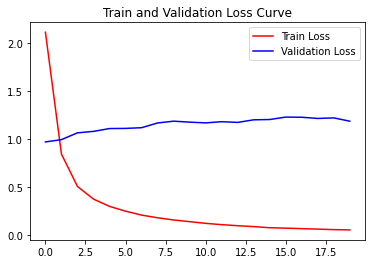

In [16]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

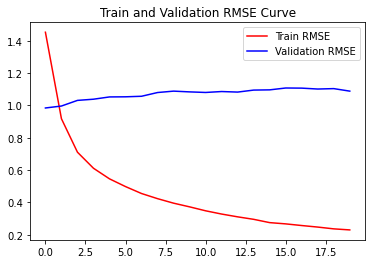

In [17]:
train_loss = hist.history['root_mean_squared_error']
val_loss = hist.history['val_root_mean_squared_error']
plt.plot(train_loss, color='r', label='Train RMSE')
plt.plot(val_loss, color='b', label='Validation RMSE')
plt.title("Train and Validation RMSE Curve")
plt.legend()
plt.show()

In [19]:
opt = tf.optimizers.Adam(learning_rate=.001)
model.compile(optimizer=opt, 
              loss=keras.losses.MeanSquaredLogarithmicError(), 
              metrics = 'accuracy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 15)        177150      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 15)        567300      input_2[0][0]                    
______________________________________________________________________________________________

In [20]:
hist = model.fit([X_train.movie, X_train.user], 
                 X_train.rating_score,  
                 batch_size=64, epochs=20, verbose=1, validation_split=.2)

Epoch 1/20
575/575 [==============================] - 14s 21ms/step - loss: 0.0029 - accuracy: 0.0304 - val_loss: 0.0687 - val_accuracy: 0.0290
Epoch 2/20
575/575 [==============================] - 13s 22ms/step - loss: 0.0031 - accuracy: 0.0311 - val_loss: 0.0698 - val_accuracy: 0.0290
Epoch 3/20
575/575 [==============================] - 13s 22ms/step - loss: 0.0033 - accuracy: 0.0316 - val_loss: 0.0679 - val_accuracy: 0.0290
Epoch 4/20
575/575 [==============================] - 13s 22ms/step - loss: 0.0029 - accuracy: 0.0302 - val_loss: 0.0699 - val_accuracy: 0.0290
Epoch 5/20
575/575 [==============================] - 10s 17ms/step - loss: 0.0026 - accuracy: 0.0309 - val_loss: 0.0718 - val_accuracy: 0.0290
Epoch 6/20
575/575 [==============================] - 10s 16ms/step - loss: 0.0024 - accuracy: 0.0312 - val_loss: 0.0711 - val_accuracy: 0.0290
Epoch 7/20
575/575 [==============================] - 11s 19ms/step - loss: 0.0022 - accuracy: 0.0308 - val_loss: 0.0708 - val_accuracy:

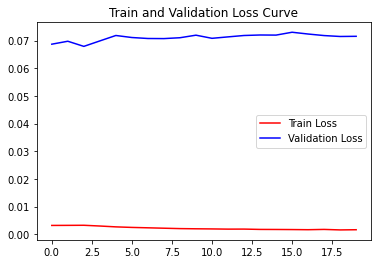

In [21]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

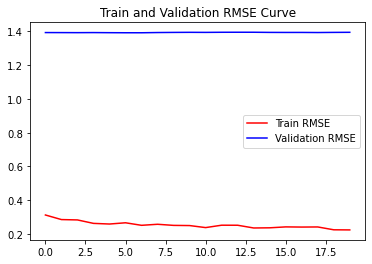

In [30]:
train_loss = hist.history['root_mean_squared_error']
val_loss = hist.history['val_root_mean_squared_error']
plt.plot(train_loss, color='r', label='Train RMSE')
plt.plot(val_loss, color='b', label='Validation RMSE')
plt.title("Train and Validation RMSE Curve")
plt.legend()
plt.show()

In [47]:
opt = tf.optimizers.Adam(learning_rate=.001)
model.compile(optimizer=opt, 
              loss=keras.losses.CosineSimilarity(), 
              metrics = keras.metrics.RootMeanSquaredError())

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 15)        177150      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 15)        567300      input_4[0][0]                    
____________________________________________________________________________________________

In [43]:
X_train = X_train.astype(float)

In [45]:
X_train

,movie,user,rating_score
26362,196.0,15449.0,3.0
45316,1232.0,3829.0,4.0
58213,9635.0,7389.0,3.0
59559,216.0,16407.0,1.0
46282,144.0,35107.0,5.0
...,...,...,...
37194,10433.0,32746.0,4.0
6265,1269.0,4096.0,3.0
54886,450.0,33617.0,4.0
860,230.0,26746.0,5.0


In [48]:
hist = model.fit([X_train.movie, X_train.user], 
                 X_train.rating_score,  
                 batch_size=64, epochs=20, verbose=1, validation_split=.2)

Epoch 1/20
575/575 [==============================] - 18s 28ms/step - loss: -0.8358 - root_mean_squared_error: 3.9044 - val_loss: -1.0000 - val_root_mean_squared_error: 3.6872
Epoch 2/20
575/575 [==============================] - 15s 25ms/step - loss: -1.0000 - root_mean_squared_error: 3.5956 - val_loss: -1.0000 - val_root_mean_squared_error: 3.3252
Epoch 3/20
575/575 [==============================] - 13s 23ms/step - loss: -1.0000 - root_mean_squared_error: 3.2037 - val_loss: -1.0000 - val_root_mean_squared_error: 2.8400
Epoch 4/20
575/575 [==============================] - 10s 17ms/step - loss: -1.0000 - root_mean_squared_error: 2.6637 - val_loss: -1.0000 - val_root_mean_squared_error: 2.2516
Epoch 5/20
575/575 [==============================] - 11s 19ms/step - loss: -1.0000 - root_mean_squared_error: 2.0427 - val_loss: -1.0000 - val_root_mean_squared_error: 1.3104
Epoch 6/20
575/575 [==============================] - 17s 29ms/step - loss: -1.0000 - root_mean_squared_error: 1.2494 - 

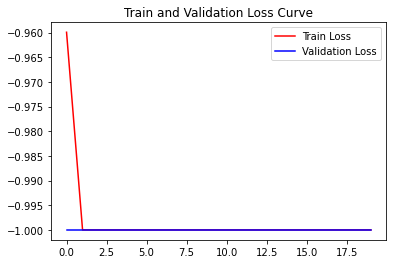

In [49]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

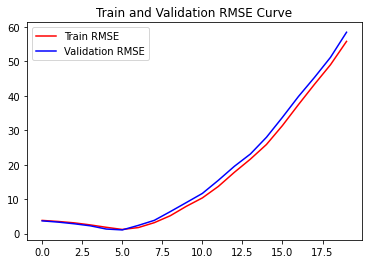

In [50]:
train_loss = hist.history['root_mean_squared_error']
val_loss = hist.history['val_root_mean_squared_error']
plt.plot(train_loss, color='r', label='Train RMSE')
plt.plot(val_loss, color='b', label='Validation RMSE')
plt.title("Train and Validation RMSE Curve")
plt.legend()
plt.show()

In [25]:
ratings.groupby('user_id').count().sort_values(by='movie_id',ascending=False)

,movie_id,rating_score,user,movie
user_id,,,,
31794511,13,13,13,13
29857588,12,12,12,12
70435183,12,12,12,12
79854948,12,12,12,12
97493409,11,11,11,11
...,...,...,...,...
57729959,1,1,1,1
29922095,1,1,1,1
57725780,1,1,1,1


In [26]:
ratings[ratings.user_id==31794511]

,movie_id,rating_score,user_id,user,movie
3012,29767,4,31794511,12024,5869
4058,14782,3,31794511,12024,3397
7505,2112,4,31794511,12024,1487
12027,26319,5,31794511,12024,5287
24369,499,4,31794511,12024,411
26342,20183,1,31794511,12024,3827
39462,795,3,31794511,12024,649
41706,31427,4,31794511,12024,6172
46484,2325,5,31794511,12024,1611
47670,2703,5,31794511,12024,1811


In [63]:
movie_array = ratings[ratings.user_id==31794511].movie.values.astype(int)
user = np.array([int(12024) for n in range(len(movie_array))])

In [64]:
movie_array.shape, movie_array.dtype, user.shape, user.dtype

((13,), dtype('int64'), (13,), dtype('int64'))

In [65]:
pred = model.predict([movie_array, user])

In [66]:
list(zip(zip(pred.flatten(), ratings[ratings.user_id==31794511].rating_score.values),movie_array))

[((4.193902, 4), 5869),
 ((3.948342, 3), 3397),
 ((4.187209, 4), 1487),
 ((4.0150485, 5), 5287),
 ((4.001645, 4), 411),
 ((3.8334882, 1), 3827),
 ((4.482376, 3), 649),
 ((4.212425, 4), 6172),
 ((4.767973, 5), 1611),
 ((4.5517263, 5), 1811),
 ((3.8925762, 4), 2216),
 ((4.089591, 4), 1934),
 ((4.2476206, 2), 2170)]